# Convolutional Networks
So far we have worked with deep fully-connected networks, using them to explore different optimization strategies and network architectures. Fully-connected networks are a good testbed for experimentation because they are very computationally efficient, but in practice all state-of-the-art results use convolutional networks instead.

First you will implement several layer types that are used in convolutional networks. You will then use these layers to train a convolutional network on the CIFAR-10 dataset.

In [1]:
# As usual, a bit of setup

import numpy as np
import matplotlib.pyplot as plt
from cnn import *
from data_utils import get_CIFAR10_data
from gradient_check import eval_numerical_gradient_array, eval_numerical_gradient
from layers import *
from fast_layers import *
from solver import Solver

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

In [7]:
# Load the (preprocessed) CIFAR10 data.

data = get_CIFAR10_data()
for k, v in data.iteritems():
  print '%s: ' % k, v.shape

X_val:  (1000, 3, 32, 32)
X_train:  (49000, 3, 32, 32)
X_test:  (1000, 3, 32, 32)
y_val:  (1000,)
y_train:  (49000,)
y_test:  (1000,)


# Convolution: Naive backward pass
Implement the backward pass for the convolution operation in the function `conv_backward_naive` in the file `layers.py`. Again, you don't need to worry too much about computational efficiency.

When you are done, run the following to check your backward pass with a numeric gradient check.

In [5]:
from fancy_conv import *
x = np.random.randn(4, 3, 6, 6)
y = np.random.randn(4, 3, 6, 6)
dout = np.random.randn(4,3,16,16)
weave_param = {'num_zeros': 2, 'filter_size': 3}

dx_num_zero_weave  = eval_numerical_gradient_array(lambda x: zero_weave_forward(x, weave_param)[0], x, dout)
dx_num_per_weave = eval_numerical_gradient_array(lambda x: array_weave_forwards(x, weave_param)[0], x, dout)

add_out = array_sum_backwards(x, y)
zero_out, zero_cache = zero_weave_forward(x, weave_param)
weave_out, weave_cache = array_weave_forwards(x, weave_param)

dx_zero = zero_weave_backwards(dout, zero_cache)
dx_weave = array_weave_backwards(dout, weave_cache)
# Your errors should be around 1e-9'
print 'Testing conv_backward_naive function'
print 'dx zero weave error: ', rel_error(dx_zero, dx_num_zero_weave)
print 'dx per weave error: ', rel_error(dx_num_per_weave, dx_weave)
print(dx_num_per_weave[0][0])
print()
print(dx_weave[0][0])

Testing conv_backward_naive function
dx zero weave error:  3.27564369120376e-12
dx per weave error:  1.0
[[ 1.65899061  1.12703316 -0.22099148  0.97284734  1.90966488  0.61153041]
 [ 0.70363148 -2.48657792  2.28929002 -1.30518567  2.01925756 -1.02794451]
 [-1.37897476 -1.78990216 -1.4585457  -0.91548224 -0.94248339  0.43612413]
 [ 0.35856195 -2.30424596 -0.53061762 -0.84938286  0.35725933  0.64950313]
 [-1.39433831  0.20272528  0.10236235  1.69208288 -1.1298912  -0.82670011]
 [-1.62233906  0.34280406  0.77613454  1.69955614  0.4740891   0.06848943]]
()
[[ 0.86458575  0.14169158  0.17411754  0.36579656  1.1478331   0.43392622]
 [ 1.17443437 -1.37561163  0.80993632 -0.47162512  0.63502818  1.01822012]
 [-0.13723467 -0.74501265  0.25105608  0.2925804   0.36297842 -0.06198721]
 [-0.40252646  0.24490312  0.016895   -0.28440095 -0.2555128   0.34267269]
 [ 0.59994875  0.56103719 -0.74082332 -0.44528355 -0.95009584 -0.50579071]
 [-1.63133083  0.4219968   0.49883229  0.25691343 -0.71004389  1.7

# Three-layer ConvNet
Now that you have implemented all the necessary layers, we can put them together into a simple convolutional network.

Open the file `cnn.py` and complete the implementation of the `ThreeLayerConvNet` class. Run the following cells to help you debug:

## Sanity check loss
After you build a new network, one of the first things you should do is sanity check the loss. When we use the softmax loss, we expect the loss for random weights (and no regularization) to be about `log(C)` for `C` classes. When we add regularization this should go up.

In [3]:
model = ThreeLayerFancyNet()

m = 50
X = np.random.randn(m, 3, 32, 32)
y = np.random.randint(10, size=m)

loss, grads = model.loss(X, y)
print 'Initial loss (no regularization): ', loss

model.reg = 0.5
loss, grads = model.loss(X, y)
print 'Initial loss (with regularization): ', loss

Initial loss (no regularization):  2.302661410359583
Initial loss (with regularization):  2.5102407995740985


## Gradient check
After the loss looks reasonable, use numeric gradient checking to make sure that your backward pass is correct. When you use numeric gradient checking you should use a small amount of artifical data and a small number of neurons at each layer.

In [4]:
num_inputs = 2
input_dim = (3, 16, 16)
reg = 0.0
num_classes = 10
X = np.random.randn(num_inputs, *input_dim)
y = np.random.randint(num_classes, size=num_inputs)

model = ThreeLayerFancyNet(num_filters=3, filter_size=3,
                          input_dim=input_dim, hidden_dim=7,
                          dtype=np.float64)
loss, grads = model.loss(X, y)
for param_name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    param_grad_num = eval_numerical_gradient(f, model.params[param_name], verbose=False, h=1e-6)
    e = rel_error(param_grad_num, grads[param_name])
    print '%s max relative error: %e' % (param_name, rel_error(param_grad_num, grads[param_name]))

theta_affine_1 max relative error: 3.278778e-02
theta_affine_1_0 max relative error: 1.000000e+00
theta_affine_2 max relative error: 6.588424e-03
theta_affine_2_0 max relative error: 1.134337e-09
theta_large max relative error: 2.166741e-02
theta_large_0 max relative error: 1.746001e-01
theta_loc max relative error: 3.127068e-02
theta_loc_0 max relative error: 1.160844e-02
theta_per max relative error: 1.000000e+00
theta_per_0 max relative error: 4.531490e-01


## Overfit small data
A nice trick is to train your model with just a few training samples. You should be able to overfit small datasets, which will result in very high training accuracy (very close to 1.00) and comparatively low validation accuracy (in the 0.20-0.25 range).

In [14]:
num_train = 1000
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}
model_fanc = ThreeLayerFancyNet(weight_scale=1e-2)

solver = Solver(model_fanc, small_data,
                num_epochs=20, batch_size=50,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-3,
                },
                verbose=True, print_every=10)
solver.train()

(Iteration 1 / 400) loss: 2.307388
(Epoch 0 / 20) train acc: 0.162000; val_acc: 0.186000
(Iteration 11 / 400) loss: 2.146093
(Epoch 1 / 20) train acc: 0.322000; val_acc: 0.289000
(Iteration 21 / 400) loss: 1.881043
(Iteration 31 / 400) loss: 1.914563
(Epoch 2 / 20) train acc: 0.409000; val_acc: 0.356000
(Iteration 41 / 400) loss: 1.736787
(Iteration 51 / 400) loss: 1.464442
(Epoch 3 / 20) train acc: 0.491000; val_acc: 0.389000
(Iteration 61 / 400) loss: 1.589022
(Iteration 71 / 400) loss: 1.297013
(Epoch 4 / 20) train acc: 0.566000; val_acc: 0.365000
(Iteration 81 / 400) loss: 1.125759
(Iteration 91 / 400) loss: 1.048256
(Epoch 5 / 20) train acc: 0.654000; val_acc: 0.384000
(Iteration 101 / 400) loss: 0.942782
(Iteration 111 / 400) loss: 0.924817
(Epoch 6 / 20) train acc: 0.748000; val_acc: 0.395000
(Iteration 121 / 400) loss: 0.765545
(Iteration 131 / 400) loss: 0.616802
(Epoch 7 / 20) train acc: 0.846000; val_acc: 0.365000
(Iteration 141 / 400) loss: 0.480597
(Iteration 151 / 400) lo

In [15]:
num_train = 1000
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}
model_norm = ThreeLayerNet(weight_scale=1e-2)

solver = Solver(model, small_data,
                num_epochs=20, batch_size=50,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-3,
                },
                verbose=True, print_every=10)
solver.train()

(Iteration 1 / 400) loss: 0.510336
(Epoch 0 / 20) train acc: 0.680000; val_acc: 0.351000
(Iteration 11 / 400) loss: 0.748508
(Epoch 1 / 20) train acc: 0.805000; val_acc: 0.414000
(Iteration 21 / 400) loss: 1.126448
(Iteration 31 / 400) loss: 0.500039
(Epoch 2 / 20) train acc: 0.874000; val_acc: 0.408000
(Iteration 41 / 400) loss: 0.656668
(Iteration 51 / 400) loss: 0.277362
(Epoch 3 / 20) train acc: 0.885000; val_acc: 0.385000
(Iteration 61 / 400) loss: 0.415932
(Iteration 71 / 400) loss: 0.377801
(Epoch 4 / 20) train acc: 0.932000; val_acc: 0.398000
(Iteration 81 / 400) loss: 0.121418
(Iteration 91 / 400) loss: 0.394707
(Epoch 5 / 20) train acc: 0.938000; val_acc: 0.403000
(Iteration 101 / 400) loss: 0.241739
(Iteration 111 / 400) loss: 0.219404
(Epoch 6 / 20) train acc: 0.953000; val_acc: 0.389000
(Iteration 121 / 400) loss: 0.194828
(Iteration 131 / 400) loss: 0.141148
(Epoch 7 / 20) train acc: 0.971000; val_acc: 0.406000
(Iteration 141 / 400) loss: 0.058354
(Iteration 151 / 400) lo

Plotting the loss, training accuracy, and validation accuracy should show clear overfitting:

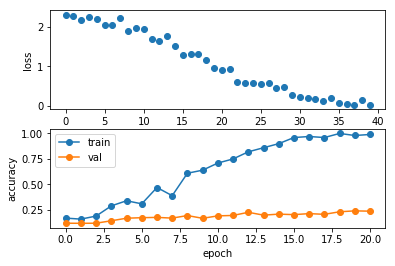

In [9]:
plt.subplot(2, 1, 1)
plt.plot(solver.loss_history, 'o')
plt.xlabel('iteration')
plt.ylabel('loss')

plt.subplot(2, 1, 2)
plt.plot(solver.train_acc_history, '-o')
plt.plot(solver.val_acc_history, '-o')
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

## Train the net
By training the three-layer convolutional network for one epoch, you should achieve greater than 40% accuracy on the training set:

In [16]:
model_full = ThreeLayerFancyNet(weight_scale=0.001, hidden_dim=500, reg=0.001)

solver = Solver(model_full, data,
                num_epochs=20, batch_size=50,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-3,
                },
                verbose=True, print_every=20)
solver.train()

(Iteration 1 / 19600) loss: 2.304694
(Epoch 0 / 20) train acc: 0.110000; val_acc: 0.105000
(Iteration 21 / 19600) loss: 2.258760
(Iteration 41 / 19600) loss: 2.164145
(Iteration 61 / 19600) loss: 1.950672
(Iteration 81 / 19600) loss: 2.239709
(Iteration 101 / 19600) loss: 1.837248
(Iteration 121 / 19600) loss: 1.875105
(Iteration 141 / 19600) loss: 1.599821
(Iteration 161 / 19600) loss: 1.715065
(Iteration 181 / 19600) loss: 1.687525
(Iteration 201 / 19600) loss: 1.645962
(Iteration 221 / 19600) loss: 1.826078
(Iteration 241 / 19600) loss: 1.685568
(Iteration 261 / 19600) loss: 1.700723
(Iteration 281 / 19600) loss: 1.759411
(Iteration 301 / 19600) loss: 1.922218
(Iteration 321 / 19600) loss: 1.286605
(Iteration 341 / 19600) loss: 1.586132
(Iteration 361 / 19600) loss: 1.645766
(Iteration 381 / 19600) loss: 1.378046
(Iteration 401 / 19600) loss: 1.384243
(Iteration 421 / 19600) loss: 1.548324
(Iteration 441 / 19600) loss: 1.609582
(Iteration 461 / 19600) loss: 1.671746
(Iteration 481 /

KeyboardInterrupt: 

## Visualize Filters
You can visualize the first-layer convolutional filters from the trained network by running the following:

In [ ]:
from vis_utils import visualize_grid

grid = visualize_grid(model.params['theta1'].transpose(0, 2, 3, 1))
plt.imshow(grid.astype('uint8'))
plt.axis('off')
plt.gcf().set_size_inches(5, 5)
plt.show()

# Experiment!
Experiment and try to get the best performance that you can on CIFAR-10 using a ConvNet. Here are some ideas to get you started:

### Things you should try:
- Filter size: Above we used 7x7; this makes pretty pictures but smaller filters may be more efficient
- Number of filters: Above we used 32 filters. Do more or fewer do better?
- Network architecture: The network above has two layers of trainable parameters. Can you do better with a deeper network? You can implement alternative architectures in the file `convnet.py`. Some good architectures to try include:
    - [conv-relu-pool]xN - conv - relu - [affine]xM - [softmax or SVM]
    - [conv-relu-pool]XN - [affine]XM - [softmax or SVM]
    - [conv-relu-conv-relu-pool]xN - [affine]xM - [softmax or SVM]

### Tips for training
For each network architecture that you try, you should tune the learning rate and regularization strength. When doing this there are a couple important things to keep in mind:

- If the parameters are working well, you should see improvement within a few hundred iterations
- Remember the course-to-fine approach for hyperparameter tuning: start by testing a large range of hyperparameters for just a few training iterations to find the combinations of parameters that are working at all.
- Once you have found some sets of parameters that seem to work, search more finely around these parameters. You may need to train for more epochs.

### Going above and beyond
If you are feeling adventurous there are many other features you can implement to try and improve your performance. You are **not required** to implement any of these; however they would be good things to try for extra credit.

- Alternative update steps: For the assignment we implemented SGD+momentum, RMSprop, and Adam; you could try alternatives like AdaGrad or AdaDelta.
- Alternative activation functions such as leaky ReLU
- Model ensembles
- Data augmentation

If you do decide to implement something extra, clearly describe it in the "Extra Credit Description" cell below.

### What we expect
At the very least, you should be able to train a ConvNet that gets at least 65% accuracy on the validation set. This is just a lower bound - if you are careful it should be possible to get accuracies much higher than that! Extra credit points will be awarded for particularly high-scoring models or unique approaches.

You should use the space below to experiment and train your network. The final cell in this notebook should contain the training, validation, and test set accuracies for your final trained network. In this notebook you should also write an explanation of what you did, any additional features that you implemented, and any visualizations or graphs that you make in the process of training and evaluating your network.

Have fun and happy training!

In [ ]:
# Train a really good model on CIFAR-10

# Extra Credit Description
If you implement any additional features for extra credit, clearly describe them here with pointers to any code in this or other files if applicable.

We implemented a new Non-Linear Function: Exponential Linear Unit.

ELU(X) = x for x>0, = exp(x) -1 for x<= 0

This can be seen in the following cells, and be found in layers.py and layers utlis.py

All following networks use ELUS.

We found that ELU conv net memorizes 50 examples faster than the same network with ReLu.

We ran two different modesls BestNet and BestNet2 that have their "geometries" in the class doc strings.

The Last Network we ran get a Val Accuracy of 73.9%.

# ELU (Eponential Linear Unit Check)
After preforming some simple research we found a possibly superior method to Leaky ReLu which was ELU and found the implementation very easy.
In the following cells we check our implemntation of ELU which can be found in layer_utils.py

In [10]:
from layer_utils import conv_elu_pool_forward, conv_elu_pool_backward

x = np.random.randn(2, 3, 16, 16)
theta = np.random.randn(3, 3, 3, 3)
theta0 = np.random.randn(3,)
dout = np.random.randn(2, 3, 8, 8)
conv_param = {'stride': 1, 'pad': 1}
pool_param = {'pool_height': 2, 'pool_width': 2, 'stride': 2}

out, cache = conv_elu_pool_forward(x, theta, theta0, conv_param, pool_param)
dx, dtheta, dtheta0 = conv_elu_pool_backward(dout, cache)

dx_num = eval_numerical_gradient_array(lambda x: conv_elu_pool_forward(x, theta, theta0, conv_param, pool_param)[0], x, dout)
dtheta_num = eval_numerical_gradient_array(lambda w: conv_elu_pool_forward(x, theta, theta0, conv_param, pool_param)[0], theta, dout)
dtheta0_num = eval_numerical_gradient_array(lambda b: conv_elu_pool_forward(x, theta, theta0, conv_param, pool_param)[0], theta0, dout)
print 'Testing conv_elu_pool'
print 'dx error: ', rel_error(dx_num, dx)
print 'dtheta error: ', rel_error(dtheta_num, dtheta)
print 'dtheta0 error: ', rel_error(dtheta0_num, dtheta0)

Testing conv_elu_pool
dx error:  1.5278856439353933e-07
dtheta error:  4.4277686235391647e-10
dtheta0 error:  1.001467179037312e-11


# Checking if our CONV ELU 3 Layer neural network will learn better than the CONV RELU 3 Layer

In [ ]:
num_train = 100
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

model = ThreeLayerConvEluNet(weight_scale=1e-2)

solver = Solver(model, small_data,
                num_epochs=20, batch_size=50,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-3,
                },
                verbose=True, print_every=1)
solver.train()

Plotting ELU Loss

In [ ]:
plt.subplot(2, 1, 1)
plt.plot(solver.loss_history, 'o')
plt.xlabel('iteration')
plt.ylabel('loss')

plt.subplot(2, 1, 2)
plt.plot(solver.train_acc_history, '-o')
plt.plot(solver.val_acc_history, '-o')
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

When compared to the same Convolution Net with ReLu which can be seen in a previous cell. This network learns faster significantly.

# Training Custom Convolutional Net to Reach 65% acc
Code can be found in cnn.py under BestNet, BestNet2

In [ ]:
num_inputs = 2
input_dim = (3, 16, 16)
reg = 0.0
num_classes = 10
X = np.random.randn(num_inputs, *input_dim)
y = np.random.randint(num_classes, size=num_inputs)

model = BestNet(num_filters=3, filter_size=3,
                          input_dim=input_dim, hidden_dim=7,
                          dtype=np.float64)
loss, grads = model.loss(X, y)
for param_name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    param_grad_num = eval_numerical_gradient(f, model.params[param_name], verbose=False, h=1e-6)
    e = rel_error(param_grad_num, grads[param_name])
    print '%s max relative error: %e' % (param_name, rel_error(param_grad_num, grads[param_name]))

This shows that the Net Learsn and nearly memorizes 1000 examples

In [7]:
num_train = 1000
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

model = BestNet(weight_scale=1e-2)

solver = Solver(model, small_data,
                num_epochs=20, batch_size=50,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-3,
                },
                verbose=True, print_every=1000)
solver.train()

(1000, 3, 31, 31)


NameError: name 'BestNet' is not defined

The model without regulizaration preforms above 65% but still is overfitted with the full data set. Running it again with a slight regularization of .01 improves over fitting but not perfectly. 

In [ ]:
model = BestNet(weight_scale=1e-2)

solver = Solver(model, data,
                num_epochs=20, batch_size=50,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-3,
                },
                verbose=True, print_every=1000)
solver.train()

In [ ]:
model = BestNet(weight_scale=1e-2, reg = .01)

solver = Solver(model, data,
                num_epochs=20, batch_size=50,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-3,
                },
                verbose=True, print_every=1000)
solver.train()

In [ ]:
model3 = BestNet2(weight_scale=1e-2, reg = .01)

num_train = 1000
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

solver = Solver(model3, small_data,
                num_epochs=20, batch_size=50,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-3,
                },
                verbose=True, print_every=1000)
solver.train()

In [ ]:
model3 = BestNet2(weight_scale=1e-2)

solver = Solver(model3, data,
                num_epochs=20, batch_size=50,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-3,
                },
                verbose=True, print_every=1000)
solver.train()

In [ ]:
model4 = BestNet2(weight_scale=1e-2, reg = 0.02)

solver = Solver(model4, data,
                num_epochs=20, batch_size=50,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-3,
                },
                verbose=True, print_every=1000)
solver.train()